## Parte 2 : Optimización de filas de espera para los estudios

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

df_raw = pd.read_csv('DataTiempos.csv')
df_raw.head()

,Sucursal,EstudioModalidad,ReservacionSP,TEPFechaEspera,TEPHoraInicio,TEPHoraFin,TEPMinutos,TAPFechaAtencion,TAPHoraInicio,TAPHoraFin,TAPMinutos
0,COYOACAN,DENSITOMETRIA,806115606,20250302,2025-03-02 13:20:00,2025-03-02T11:40:15.1130000,0.00,20250302,2025-03-02T11:40:15.1130000,2025-03-02T11:47:18.1700000,7.05
1,COYOACAN,DENSITOMETRIA,918870299,20250329,2025-03-29 07:11:15.77,2025-03-29T07:39:49.4000000,28.57,20250329,2025-03-29T07:39:49.4000000,2025-03-29T07:45:18.2300000,5.48
2,COYOACAN,DENSITOMETRIA,921436045,20250321,2025-03-21 15:55:53.723,2025-03-21T16:15:07.2300000,19.23,20250321,2025-03-21T16:15:07.2300000,2025-03-21T16:21:50.1270000,6.72
3,COYOACAN,DENSITOMETRIA,923595474,20250301,2025-03-01 08:03:01.36,2025-03-01T09:42:16.9900000,99.25,20250301,2025-03-01T09:42:16.9900000,2025-03-01T09:48:03.5770000,5.78
4,COYOACAN,DENSITOMETRIA,926170090,20250302,2025-03-02 09:40:00,2025-03-02T09:20:46.2400000,0.00,20250302,2025-03-02T09:20:46.2400000,2025-03-02T09:27:47.6170000,7.02


In [119]:
consultorios = pd.read_csv('Consultorios.csv')
consultorios.head()

,Sucursal,EstudioModalidad,NumConsultorios
0,CULIACAN COLEGIO MILITAR,LABORATORIO,4
1,COYOACAN,PAPANICOLAOU,1
2,CULIACAN UNIVERSITARIOS,ULTRASONIDO,2
3,CULIACAN COLEGIO MILITAR,RAYOS X,1
4,CULIACAN NAKAYAMA,PAPANICOLAOU,1


### Inputación de datos faltantes

In [120]:
df_raw['TEPMinutos'] = pd.to_numeric(df_raw['TEPMinutos'], errors='coerce')
df_raw['TAPMinutos'] = pd.to_numeric(df_raw['TAPMinutos'], errors='coerce')
# Calculate the total time for each study event
df_raw['TotalMinutos'] = df_raw['TEPMinutos'] + df_raw['TAPMinutos']

initial_rows = df_raw.shape[0]
df_raw.dropna(subset=['TotalMinutos', 'Sucursal', 'EstudioModalidad'], inplace=True)
final_rows = df_raw.shape[0]

print(f"Dropped {initial_rows - final_rows} rows with missing data.")
print("Cleaned DataFrame head:")
df = df_raw.copy()

Dropped 3066 rows with missing data.
Cleaned DataFrame head:


In [121]:
df.shape

(106101, 12)

In [147]:
df['Sucursal'].unique()

array(['COYOACAN', 'CULIACAN', 'CULIACAN CAÑADAS',
       'CULIACAN COLEGIO MILITAR', 'CULIACAN LA CONQUISTA',
       'CULIACAN LAS TORRES', 'CULIACAN NAKAYAMA',
       'CULIACAN UNIVERSITARIOS'], dtype=object)

In [149]:
df[df['Sucursal']=='CULIACAN NAKAYAMA']['TAPFechaAtencion'].value_counts()

TAPFechaAtencion
20250301    152
20250304    136
20250322    131
20250331    125
20250329    120
20250311    116
20250308    115
20250310    115
20250324    112
20250312    112
20250305    105
20250318    105
20250326    105
20250307    104
20250319    104
20250306    103
20250315    103
20250313    102
20250327    102
20250320    102
20250321     97
20250303     97
20250325     96
20250317     91
20250314     88
20250328     73
Name: count, dtype: int64

### Eliminación de Outliers

In [123]:
# Identify outliers using Z-score
z_scores = df.groupby(['Sucursal', 'EstudioModalidad'])['TAPMinutos'].transform(lambda x: np.abs(stats.zscore(x)))
threshold = 2.5 # 2 std
df_cleaned = df[z_scores < threshold].copy()

z_scores = df_cleaned.groupby(['Sucursal', 'EstudioModalidad'])['TEPMinutos'].transform(lambda x: np.abs(stats.zscore(x)))
threshold = 2.5 # 2 std
df_cleaned = df_cleaned[z_scores < threshold].copy()

print(f"Removed {df.shape[0] - df_cleaned.shape[0]} outliers based on TAPMinutos.")
# Q1 = df["TAPMinutos"].quantile(0.25)
# Q3 = df["TAPMinutos"].quantile(0.75)
# IQR = Q3 - Q1
#no_outliers_df = df_cleaned[(df_cleaned["TotalMinutos"] <= 600)]
print("DataFrame after outlier removal:")

df = df_cleaned.copy()
df.head()

Removed 2705 outliers based on TAPMinutos.
DataFrame after outlier removal:


,Sucursal,EstudioModalidad,ReservacionSP,TEPFechaEspera,TEPHoraInicio,TEPHoraFin,TEPMinutos,TAPFechaAtencion,TAPHoraInicio,TAPHoraFin,TAPMinutos,TotalMinutos
0,COYOACAN,DENSITOMETRIA,806115606,20250302,2025-03-02 13:20:00,2025-03-02T11:40:15.1130000,0.00,20250302,2025-03-02T11:40:15.1130000,2025-03-02T11:47:18.1700000,7.05,7.05
1,COYOACAN,DENSITOMETRIA,918870299,20250329,2025-03-29 07:11:15.77,2025-03-29T07:39:49.4000000,28.57,20250329,2025-03-29T07:39:49.4000000,2025-03-29T07:45:18.2300000,5.48,34.05
2,COYOACAN,DENSITOMETRIA,921436045,20250321,2025-03-21 15:55:53.723,2025-03-21T16:15:07.2300000,19.23,20250321,2025-03-21T16:15:07.2300000,2025-03-21T16:21:50.1270000,6.72,25.95
3,COYOACAN,DENSITOMETRIA,923595474,20250301,2025-03-01 08:03:01.36,2025-03-01T09:42:16.9900000,99.25,20250301,2025-03-01T09:42:16.9900000,2025-03-01T09:48:03.5770000,5.78,105.03
4,COYOACAN,DENSITOMETRIA,926170090,20250302,2025-03-02 09:40:00,2025-03-02T09:20:46.2400000,0.00,20250302,2025-03-02T09:20:46.2400000,2025-03-02T09:27:47.6170000,7.02,7.02


In [124]:
df.shape

(103396, 12)

### Analisis Exploratorio

In [125]:
def graficar_tiempo_medio_por_estudio(df, sucursal):
    df_filtrado = df[df['Sucursal'] == sucursal]
    if df_filtrado.empty:
        print(f"No hay datos para la sucursal '{sucursal}'.")
        return
    resumen = df_filtrado.groupby('EstudioModalidad')['TEPMinutos'].mean().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=resumen.values, y=resumen.index, palette="viridis")
    plt.title(f"Tiempo medio de espera por estudio - {sucursal}")
    plt.xlabel("Minutos de espera promedio (TEPMinutos)")
    plt.ylabel("EstudioModalidad")

    # Añadir etiquetas de valor a cada barra
    for i, v in enumerate(resumen.values):
        ax.text(v + 0.5, i, f"{v:.1f}", color='black', va='center')

    plt.tight_layout()
    plt.show()

C:\Users\migue\AppData\Local\Temp\ipykernel_21168\2021993210.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=resumen.values, y=resumen.index, palette="viridis")


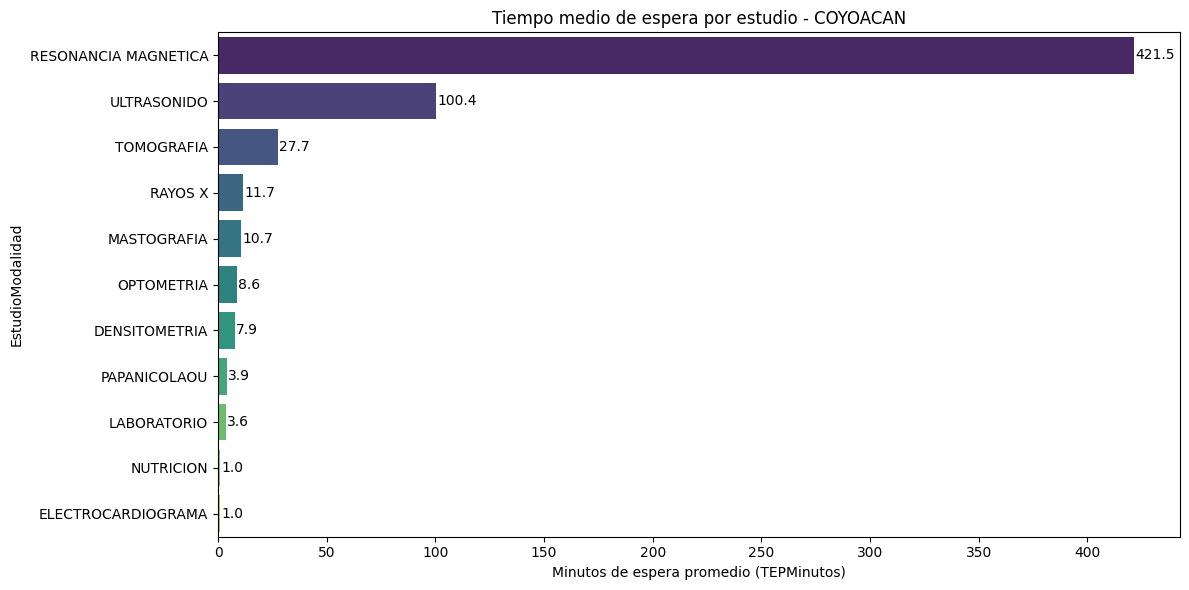

In [126]:
graficar_tiempo_medio_por_estudio(df, 'COYOACAN')

In [127]:
sample_sucursal = 'COYOACAN'
sample_estudio = 'DENSITOMETRIA'
sample_data = df[(df['Sucursal'] == sample_sucursal) & (no_outliers_df['EstudioModalidad'] == sample_estudio)]['TAPMinutos']

plt.figure(figsize=(12, 6))
sns.histplot(sample_data, kde=True, bins=100)
plt.title(f'Time Distribution for {sample_estudio} at {sample_sucursal}')
plt.xlabel('Total Time (Minutes)')
plt.ylabel('Frequency')
plt.show()

print(f"Description of sample data:\n{no_outliers_df.describe()}")

NameError: name 'no_outliers_df' is not defined

In [ ]:
def graficar_horarios_pico_estudios(df, sucursal):
    """
    Filtra por sucursal y grafica los horarios pico de estudios por periodo del día.

    Parámetros:
    - df: DataFrame con columnas 'TAPHoraInicio', 'EstudioModalidad', 'Sucursal'.
    - sucursal: (str) nombre de la sucursal a analizar.
    """
    # Filtrar por sucursal
    df_filtrado = df[df['Sucursal'] == sucursal].copy()

    if df_filtrado.empty:
        print(f"No hay datos para la sucursal '{sucursal}'.")
        return

    # Asegurar formato datetime
    df_filtrado['TAPHoraInicio'] = pd.to_datetime(df_filtrado['TAPHoraInicio'], errors='coerce')

    # Categorizar hora en periodos del día
    def get_time_interval(hour):
        if pd.isna(hour):
            return 'Desconocido'
        start = (hour // 2) * 2
        end = start + 2
        return f"{start:02d}-{end:02d}"

    df_filtrado['Intervalo2Horas'] = df_filtrado['TAPHoraInicio'].dt.hour.apply(get_time_interval)

    # Crear tabla cruzada: conteo de estudios por periodo
    heatmap_data = pd.crosstab(df_filtrado['EstudioModalidad'], df_filtrado['Intervalo2Horas'])

    # Ordenar columnas por el orden cronológico de los intervalos
    orden_intervalos = [f"{i:02d}-{i+2:02d}" for i in range(0, 24, 2)]
    heatmap_data = heatmap_data.reindex(columns=orden_intervalos, fill_value=0)

    # Graficar heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.5)
    plt.title(f"Horas pico por estudio - {sucursal}")
    plt.xlabel("Periodo del día")
    plt.ylabel("EstudioModalidad")
    plt.tight_layout()
    plt.show()
    
graficar_horarios_pico_estudios(df, 'COYOACAN')

## Extraccion de métricas relevantes

In [ ]:
# Convertir a string si es numérico, luego a datetime
df['FechaEvento'] = pd.to_datetime(df['TAPFechaAtencion'].astype(str), errors='coerce') 
df.dropna(subset=['FechaEvento'], inplace=True) # Eliminar filas donde la conversión falló
# Ordenar por fecha
df_sorted = df.sort_values(by='FechaEvento').reset_index(drop=True)

In [128]:
df_sorted.shape

(101656, 13)

In [129]:
split_index = int(len(df_sorted) * 0.80)
df_train = df_sorted.iloc[:split_index]
df_test = df_sorted.iloc[split_index:]
print(f"Datos de entrenamiento (80%): {len(df_train)} filas, desde {df_train['FechaEvento'].min()} hasta {df_train['FechaEvento'].max()}")
print(f"Datos de prueba (20%): {len(df_test)} filas, desde {df_test['FechaEvento'].min()} hasta {df_test['FechaEvento'].max()}")

Datos de entrenamiento (80%): 81324 filas, desde 2025-03-01 00:00:00 hasta 2025-03-25 00:00:00
Datos de prueba (20%): 20332 filas, desde 2025-03-25 00:00:00 hasta 2025-03-31 00:00:00


In [130]:
df_train.shape

(81324, 13)

In [131]:
import pickle
# Calculate the average TAP time for each combination of Sucursal and EstudioModalidad
average_tap_time = df_train.groupby(['Sucursal', 'EstudioModalidad'])['TAPMinutos'].mean()

# Convert the resulting Series to a dictionary
average_tap_dict = average_tap_time.to_dict()

with open('average_tap_dict.pkl', 'wb') as f:
    pickle.dump(average_tap_dict, f)
print("Diccionario average_tap_dict guardado.")

average_tap_dict

Diccionario average_tap_dict guardado.


{('COYOACAN', 'DENSITOMETRIA'): 6.323067456700091,
 ('COYOACAN', 'ELECTROCARDIOGRAMA'): 6.530370892018779,
 ('COYOACAN', 'LABORATORIO'): 3.1267071057192375,
 ('COYOACAN', 'MASTOGRAFIA'): 8.247920883164673,
 ('COYOACAN', 'NUTRICION'): 10.56888484848485,
 ('COYOACAN', 'OPTOMETRIA'): 11.027873928670168,
 ('COYOACAN', 'PAPANICOLAOU'): 7.201342281879195,
 ('COYOACAN', 'RAYOS X'): 4.47359845227859,
 ('COYOACAN', 'RESONANCIA MAGNETICA'): 37.960297699594044,
 ('COYOACAN', 'TOMOGRAFIA'): 15.488328488372092,
 ('COYOACAN', 'ULTRASONIDO'): 12.881919320594479,
 ('CULIACAN', 'DENSITOMETRIA'): 8.081452658884565,
 ('CULIACAN', 'ELECTROCARDIOGRAMA'): 7.035842857142858,
 ('CULIACAN', 'LABORATORIO'): 3.549325513196481,
 ('CULIACAN', 'MASTOGRAFIA'): 7.1806265664160405,
 ('CULIACAN', 'NUTRICION'): 12.86173645320197,
 ('CULIACAN', 'OPTOMETRIA'): 10.836588820826952,
 ('CULIACAN', 'PAPANICOLAOU'): 8.692675367047308,
 ('CULIACAN', 'RAYOS X'): 4.762819047619048,
 ('CULIACAN', 'RESONANCIA MAGNETICA'): 25.9388926

In [132]:
consultorios_grouped = consultorios.groupby(['Sucursal', 'EstudioModalidad'])['NumConsultorios'].max()
consultorios_grouped_dict = consultorios_grouped.to_dict()
with open('consultorios.pkl', 'wb') as f:
    pickle.dump(consultorios_grouped_dict, f)
print("Diccionario consultorios guardado.")

processing_rate_dict = average_tap_dict.copy()
for key in processing_rate_dict:
    processing_rate_dict[key] /= consultorios_grouped_dict[key]

with open('processing_rate_dict.pkl', 'wb') as f:
    pickle.dump(processing_rate_dict, f)
print("Diccionario processing_rate_dict guardado.")
processing_rate_dict

Diccionario consultorios guardado.
Diccionario processing_rate_dict guardado.


{('COYOACAN', 'DENSITOMETRIA'): 3.1615337283500455,
 ('COYOACAN', 'ELECTROCARDIOGRAMA'): 3.2651854460093896,
 ('COYOACAN', 'LABORATORIO'): 0.2405159312091721,
 ('COYOACAN', 'MASTOGRAFIA'): 2.749306961054891,
 ('COYOACAN', 'NUTRICION'): 5.284442424242425,
 ('COYOACAN', 'OPTOMETRIA'): 1.8379789881116946,
 ('COYOACAN', 'PAPANICOLAOU'): 7.201342281879195,
 ('COYOACAN', 'RAYOS X'): 2.236799226139295,
 ('COYOACAN', 'RESONANCIA MAGNETICA'): 37.960297699594044,
 ('COYOACAN', 'TOMOGRAFIA'): 15.488328488372092,
 ('COYOACAN', 'ULTRASONIDO'): 1.840274188656354,
 ('CULIACAN', 'DENSITOMETRIA'): 8.081452658884565,
 ('CULIACAN', 'ELECTROCARDIOGRAMA'): 7.035842857142858,
 ('CULIACAN', 'LABORATORIO'): 0.5070465018852116,
 ('CULIACAN', 'MASTOGRAFIA'): 7.1806265664160405,
 ('CULIACAN', 'NUTRICION'): 3.2154341133004927,
 ('CULIACAN', 'OPTOMETRIA'): 2.709147205206738,
 ('CULIACAN', 'PAPANICOLAOU'): 8.692675367047308,
 ('CULIACAN', 'RAYOS X'): 4.762819047619048,
 ('CULIACAN', 'RESONANCIA MAGNETICA'): 25.9388

In [133]:
df_train_og = df_train.copy()
df_train['TEPHoraInicio'] = pd.to_datetime(df_train['TEPHoraInicio'], errors='coerce')
df_train['TEPHoraFin'] = pd.to_datetime(df_train['TEPHoraFin'], errors='coerce')
df_train.dropna(subset=['TEPHoraInicio', 'TEPHoraFin'], inplace=True)
df_train['TEPTimeDelta'] = (df_train['TEPHoraFin'] - df_train['TEPHoraInicio']).dt.total_seconds() / 60
df_train = df_train[df_train['TEPTimeDelta'] > 0].copy()
df_train['IntervalStartTime'] = df_train['TEPHoraInicio'].dt.floor('30min')
average_tep_time_intervals = df_train.groupby(['Sucursal', 'EstudioModalidad', 'IntervalStartTime'])['TEPTimeDelta'].mean() 
average_tep_dict_intervals = average_tep_time_intervals.to_dict()
# Format the keys for better readability (e.g., '10:00am - 10:30 am')

formatted_average_tep_dict = {}
for (sucursal, estudio, start_time), avg_time in average_tep_dict_intervals.items():
    end_time = start_time + pd.Timedelta(minutes=30)
    time_interval_str = f"{start_time.strftime('%I:%M%p')} - {end_time.strftime('%I:%M%p')}"
    formatted_key = (sucursal, estudio, time_interval_str)
    formatted_average_tep_dict[formatted_key] = avg_time
# Print a few examples from the dictionary

print("Examples of average TEPTime per 30-minute interval:")
for i, (key, value) in enumerate(formatted_average_tep_dict.items()):
    if i < 10: # Print the first 10 entries
        print(f"{key}: {value}")
    else:
        break
with open('average_tep_dict.pkl', 'wb') as f:
    pickle.dump(formatted_average_tep_dict, f)
print("Diccionario formatted_average_tep_dict guardado.")


C:\Users\migue\AppData\Local\Temp\ipykernel_21168\168294639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['TEPHoraInicio'] = pd.to_datetime(df_train['TEPHoraInicio'], errors='coerce')
C:\Users\migue\AppData\Local\Temp\ipykernel_21168\168294639.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['TEPHoraFin'] = pd.to_datetime(df_train['TEPHoraFin'], errors='coerce')
C:\Users\migue\AppData\Local\Temp\ipykernel_21168\168294639.py:4: SettingWithCopyWarning: 
A value is trying to be set o

Examples of average TEPTime per 30-minute interval:
('COYOACAN', 'DENSITOMETRIA', '07:30AM - 08:00AM'): 3.9968833333333333
('COYOACAN', 'DENSITOMETRIA', '08:00AM - 08:30AM'): 84.21900000000001
('COYOACAN', 'DENSITOMETRIA', '08:30AM - 09:00AM'): 23.7854
('COYOACAN', 'DENSITOMETRIA', '09:30AM - 10:00AM'): 68.00155416666666
('COYOACAN', 'DENSITOMETRIA', '10:30AM - 11:00AM'): 21.115744444444445
('COYOACAN', 'DENSITOMETRIA', '11:00AM - 11:30AM'): 38.7026
('COYOACAN', 'DENSITOMETRIA', '12:00PM - 12:30PM'): 13.19761111111111
('COYOACAN', 'DENSITOMETRIA', '01:30PM - 02:00PM'): 12.634441666666667
('COYOACAN', 'DENSITOMETRIA', '03:00PM - 03:30PM'): 25.96826666666667
('COYOACAN', 'DENSITOMETRIA', '03:30PM - 04:00PM'): 11.077308333333335
Diccionario formatted_average_tep_dict guardado.


In [134]:
df_train_og.shape

(81324, 13)

In [135]:
num_unique_days = df_train['FechaEvento'].nunique()
num_unique_days

25

In [136]:
df_train = df_train_og.copy()
df_train['TEPHoraInicio'] = pd.to_datetime(df_train['TEPHoraInicio'], errors='coerce')
df_train['TEPHoraFin'] = pd.to_datetime(df_train['TEPHoraFin'], errors='coerce')
df_train.dropna(subset=['TEPHoraInicio', 'TEPHoraFin'], inplace=True)

print(df_train.shape)
df_train['StudyVal'] = 1

df_train['IntervalStartTimeWithDate'] = df_train['TEPHoraInicio'].dt.floor('30min') # Keep this if needed for other things

# Create a column that ONLY has the time slot (date-agnostic)
df_train['TimeOfDaySlot'] = df_train['IntervalStartTimeWithDate'].dt.time # Extracts datetime.time object

# Group by Sucursal, EstudioModalidad, and the date-agnostic TimeOfDaySlot
total_counts_time_intervals = df_train.groupby(
    ['Sucursal', 'EstudioModalidad', 'TimeOfDaySlot']
)['StudyVal'].sum()

# Now, format this aggregated data
formatted_total_counts_dict = {}
for (sucursal, estudio, time_slot_obj), total_count in total_counts_time_intervals.items():
    dummy_date = pd.Timestamp('1900-01-01').date()
    start_datetime_for_format = pd.Timestamp.combine(dummy_date, time_slot_obj)
    end_datetime_for_format = start_datetime_for_format + pd.Timedelta(minutes=30)
    
    time_interval_str = f"{start_datetime_for_format.strftime('%I:%M%p')} - {end_datetime_for_format.strftime('%I:%M%p')}"
    
    formatted_key = (sucursal, estudio, time_interval_str)
    formatted_total_counts_dict[formatted_key] = total_count
    
sum(formatted_total_counts_dict.values())
with open('counts_by_time_slot.pkl', 'wb') as f:
    pickle.dump(formatted_total_counts_dict, f)
print("Diccionario formatted_total_counts_dict guardado.")


(53104, 13)
Diccionario formatted_total_counts_dict guardado.


In [137]:
formatted_total_counts_dict

{('COYOACAN', 'DENSITOMETRIA', '06:00AM - 06:30AM'): 4,
 ('COYOACAN', 'DENSITOMETRIA', '06:30AM - 07:00AM'): 15,
 ('COYOACAN', 'DENSITOMETRIA', '07:00AM - 07:30AM'): 31,
 ('COYOACAN', 'DENSITOMETRIA', '07:30AM - 08:00AM'): 23,
 ('COYOACAN', 'DENSITOMETRIA', '08:00AM - 08:30AM'): 27,
 ('COYOACAN', 'DENSITOMETRIA', '08:30AM - 09:00AM'): 24,
 ('COYOACAN', 'DENSITOMETRIA', '09:00AM - 09:30AM'): 31,
 ('COYOACAN', 'DENSITOMETRIA', '09:30AM - 10:00AM'): 47,
 ('COYOACAN', 'DENSITOMETRIA', '10:00AM - 10:30AM'): 31,
 ('COYOACAN', 'DENSITOMETRIA', '10:30AM - 11:00AM'): 32,
 ('COYOACAN', 'DENSITOMETRIA', '11:00AM - 11:30AM'): 26,
 ('COYOACAN', 'DENSITOMETRIA', '11:30AM - 12:00PM'): 30,
 ('COYOACAN', 'DENSITOMETRIA', '12:00PM - 12:30PM'): 26,
 ('COYOACAN', 'DENSITOMETRIA', '12:30PM - 01:00PM'): 25,
 ('COYOACAN', 'DENSITOMETRIA', '01:00PM - 01:30PM'): 26,
 ('COYOACAN', 'DENSITOMETRIA', '01:30PM - 02:00PM'): 16,
 ('COYOACAN', 'DENSITOMETRIA', '02:00PM - 02:30PM'): 13,
 ('COYOACAN', 'DENSITOMETRIA', '

In [138]:
df_test.to_csv('DataTiempos_prueba.csv', index=False)

In [139]:
df_train = df_train_og.copy()
df_train['TEPHoraInicio'] = pd.to_datetime(df_train['TEPHoraInicio'], errors='coerce')
df_train['TEPHoraFin'] = pd.to_datetime(df_train['TEPHoraFin'], errors='coerce')
df_train.dropna(subset=['TEPHoraInicio', 'TEPHoraFin'], inplace=True)
df_train['StudyVal'] = 1
df_train['IntervalStartTimeWithDate'] = df_train['TEPHoraInicio'].dt.floor('10min') # Keep this if needed for other things
df_train['TimeOfDaySlot'] = df_train['IntervalStartTimeWithDate'].dt.time # Extracts datetime.time object

# Group by Sucursal and the date-agnostic TimeOfDaySlot
dist_time_intervals = df_train.groupby(
    ['Sucursal', 'TimeOfDaySlot']
)['StudyVal'].sum()

# Now, format this aggregated data
dist_counts_dict = {}
for (sucursal, time_slot_obj), total_count in dist_time_intervals.items():
    dummy_date = pd.Timestamp('1900-01-01').date()
    start_datetime_for_format = pd.Timestamp.combine(dummy_date, time_slot_obj)
    if start_datetime_for_format.hour < 6 or start_datetime_for_format.hour > 19:
        continue
    end_datetime_for_format = start_datetime_for_format + pd.Timedelta(minutes=10)
    time_interval_str = f"{start_datetime_for_format.strftime('%I:%M%p')} - {end_datetime_for_format.strftime('%I:%M%p')}"
    
    formatted_key = (sucursal, estudio, time_interval_str)
    dist_counts_dict[formatted_key] = total_count

In [140]:
dist_counts_dict

{('COYOACAN', 'ULTRASONIDO', '06:00AM - 06:10AM'): 267,
 ('COYOACAN', 'ULTRASONIDO', '06:10AM - 06:20AM'): 382,
 ('COYOACAN', 'ULTRASONIDO', '06:20AM - 06:30AM'): 448,
 ('COYOACAN', 'ULTRASONIDO', '06:30AM - 06:40AM'): 464,
 ('COYOACAN', 'ULTRASONIDO', '06:40AM - 06:50AM'): 446,
 ('COYOACAN', 'ULTRASONIDO', '06:50AM - 07:00AM'): 449,
 ('COYOACAN', 'ULTRASONIDO', '07:00AM - 07:10AM'): 578,
 ('COYOACAN', 'ULTRASONIDO', '07:10AM - 07:20AM'): 662,
 ('COYOACAN', 'ULTRASONIDO', '07:20AM - 07:30AM'): 651,
 ('COYOACAN', 'ULTRASONIDO', '07:30AM - 07:40AM'): 715,
 ('COYOACAN', 'ULTRASONIDO', '07:40AM - 07:50AM'): 758,
 ('COYOACAN', 'ULTRASONIDO', '07:50AM - 08:00AM'): 698,
 ('COYOACAN', 'ULTRASONIDO', '08:00AM - 08:10AM'): 711,
 ('COYOACAN', 'ULTRASONIDO', '08:10AM - 08:20AM'): 738,
 ('COYOACAN', 'ULTRASONIDO', '08:20AM - 08:30AM'): 716,
 ('COYOACAN', 'ULTRASONIDO', '08:30AM - 08:40AM'): 674,
 ('COYOACAN', 'ULTRASONIDO', '08:40AM - 08:50AM'): 689,
 ('COYOACAN', 'ULTRASONIDO', '08:50AM - 09:00AM'

In [141]:
distributions = {}
for key in dist_counts_dict:
    if key[0] not in distributions:
        distributions[key[0]] = []
    distributions[key[0]].append(dist_counts_dict[key])
distributions['COYOACAN'] = distributions['COYOACAN'][5:]
distributions  

{'COYOACAN': [449,
  578,
  662,
  651,
  715,
  758,
  698,
  711,
  738,
  716,
  674,
  689,
  656,
  646,
  603,
  564,
  553,
  536,
  494,
  473,
  449,
  379,
  384,
  358,
  341,
  307,
  323,
  228,
  242,
  251,
  215,
  189,
  180,
  183,
  186,
  186,
  134,
  125,
  157,
  131,
  150,
  147,
  103,
  90,
  94,
  109,
  83,
  97,
  106,
  96,
  100,
  97,
  92,
  93,
  75,
  73,
  83,
  80,
  85,
  86,
  90,
  65,
  75,
  50,
  54,
  59,
  60,
  56,
  54,
  51,
  42,
  34,
  21,
  1,
  2],
 'CULIACAN': [42,
  59,
  71,
  76,
  85,
  125,
  228,
  242,
  237,
  257,
  261,
  260,
  280,
  288,
  300,
  271,
  275,
  246,
  241,
  232,
  219,
  195,
  166,
  160,
  129,
  164,
  156,
  145,
  123,
  120,
  144,
  108,
  123,
  114,
  102,
  110,
  80,
  102,
  86,
  73,
  75,
  62,
  72,
  62,
  68,
  68,
  62,
  67,
  64,
  63,
  59,
  58,
  42,
  50,
  55,
  50,
  46,
  47,
  69,
  43,
  68,
  53,
  48,
  56,
  45,
  46,
  34,
  29,
  25,
  19,
  38,
  17,
  1,
  1],
 'CULI

In [142]:
from scipy import stats

def fit_best_distribution(data):
    if len(data) < 30: # Necesitamos suficientes puntos de datos para un ajuste significativo
        print(len(data))
        return None, None # No se puede ajustar una distribución fiable
    distributions_to_test = [stats.gamma, stats.lognorm, stats.expon, stats.norm]
    best_distribution = None
    best_params = None
    best_sse = np.inf # Sum of Squared Errors
    y, x = np.histogram(data, bins='auto', density=True) 
    x = (x + np.roll(x, -1))[:-1] / 2.0 # Puntos medios de los bins
    for distribution in distributions_to_test:
        try:
            if distribution in [stats.gamma, stats.expon, stats.lognorm]:
                params = distribution.fit(data, floc=0) 
            else:
                params = distribution.fit(data)
            pdf = distribution.pdf(x, *params)
            sse = np.sum(np.power(y - pdf, 2.0))
            if sse < best_sse:
                best_distribution = distribution
                best_params = params
                best_sse = sse
        except Exception as e:
            continue
    return best_distribution, best_params

In [143]:
def plot_dist(best_dist_obj, best_dist_params, data):
    plt.figure(figsize=(12, 7))
    if best_dist_obj and best_dist_params:
        x_plot = np.linspace(np.min(data), np.max(data), 500)
        pdf_fitted = best_dist_obj.pdf(x_plot, *best_dist_params)
        plt.plot(x_plot, pdf_fitted, 'r-', lw=2, label=f'Best Fit: {best_dist_obj.name}')
        plt.title(f'Best Fit Distribution: {best_dist_obj.name}\nParameters: {np.round(best_dist_params,3)}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show() 
    plt.close()

COYOACAN


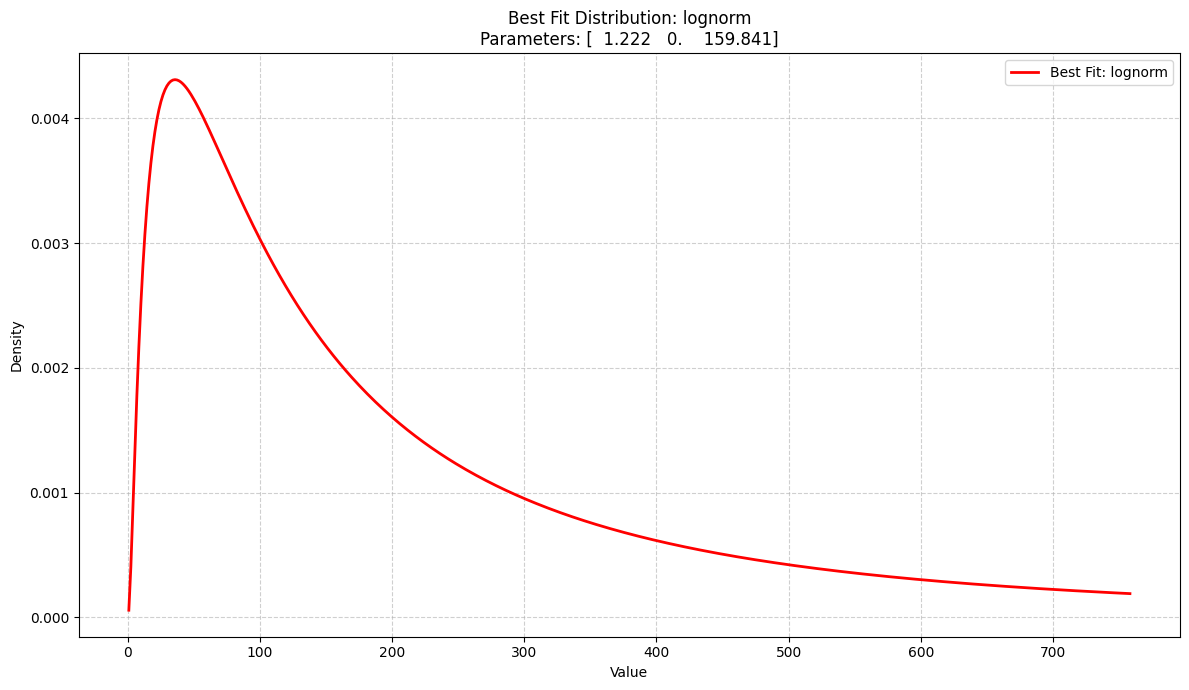

CULIACAN


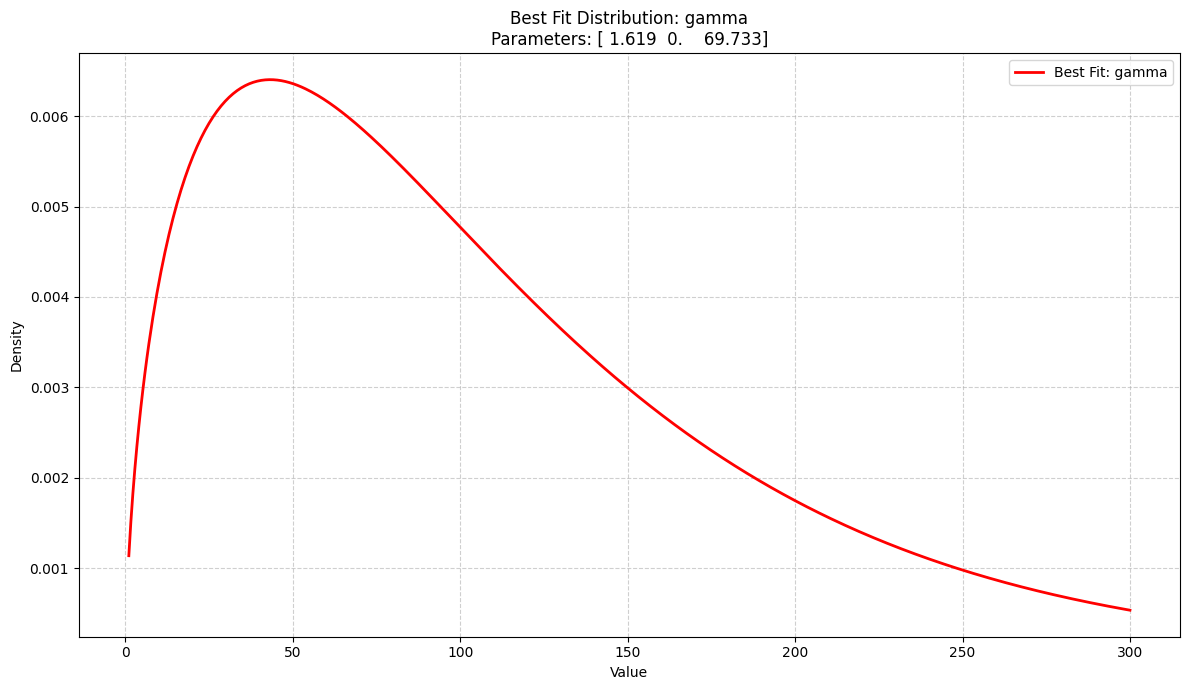

CULIACAN CAÑADAS


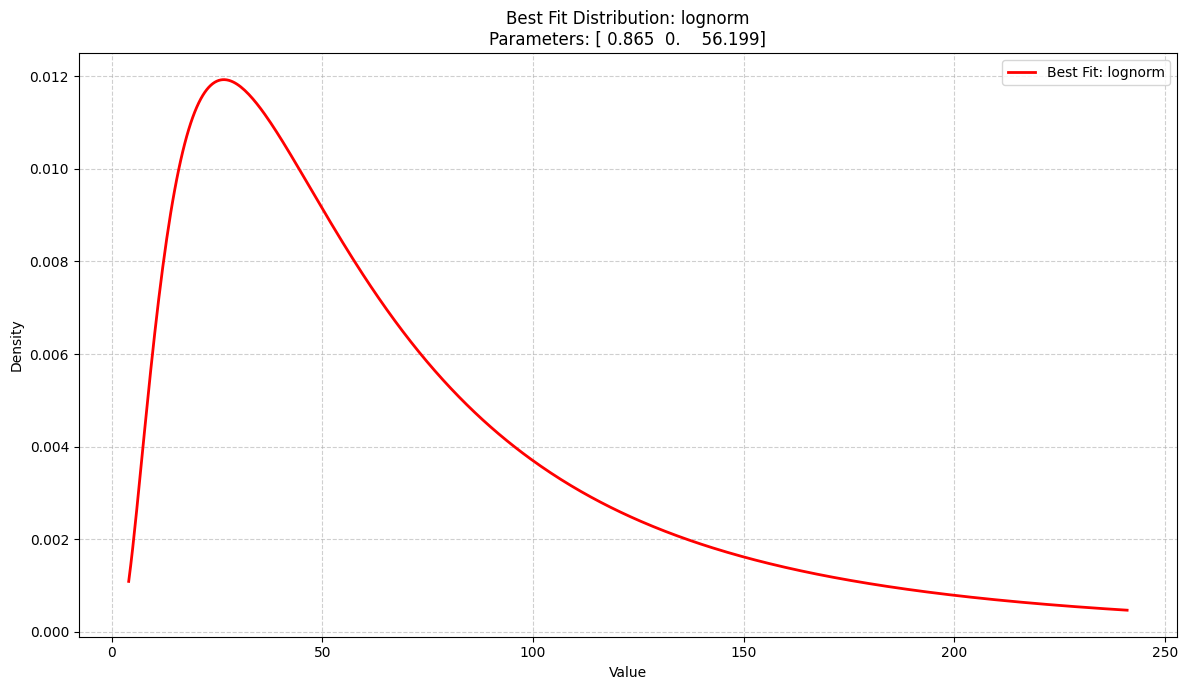

CULIACAN COLEGIO MILITAR


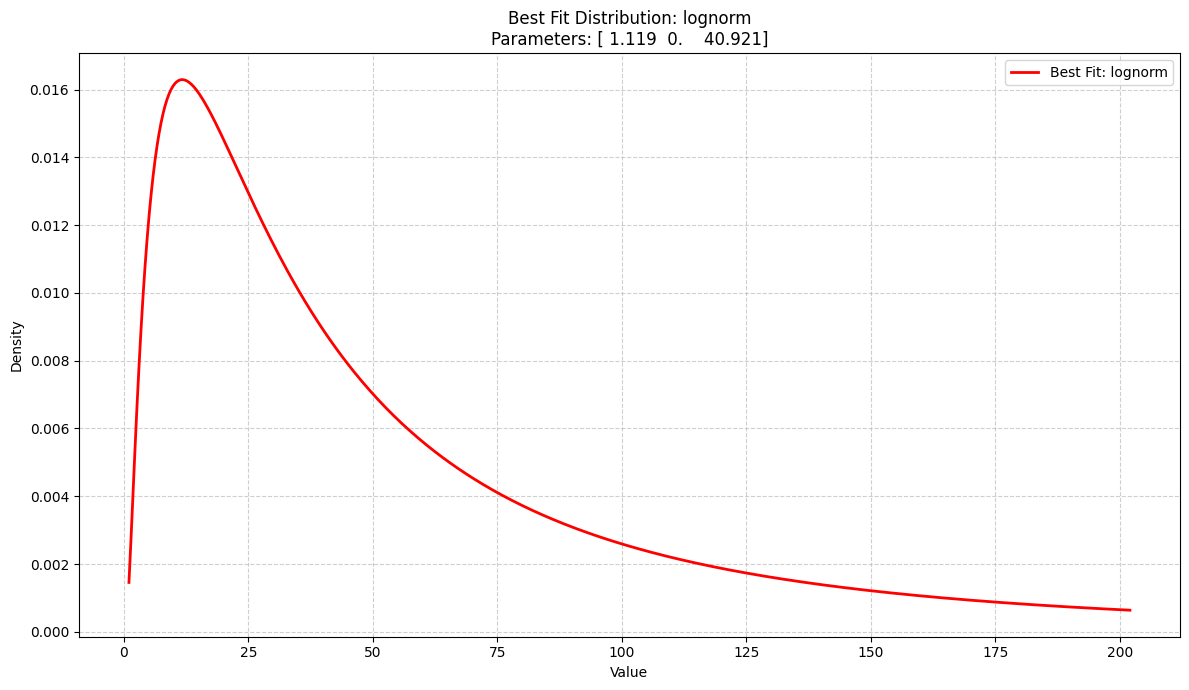

CULIACAN LA CONQUISTA


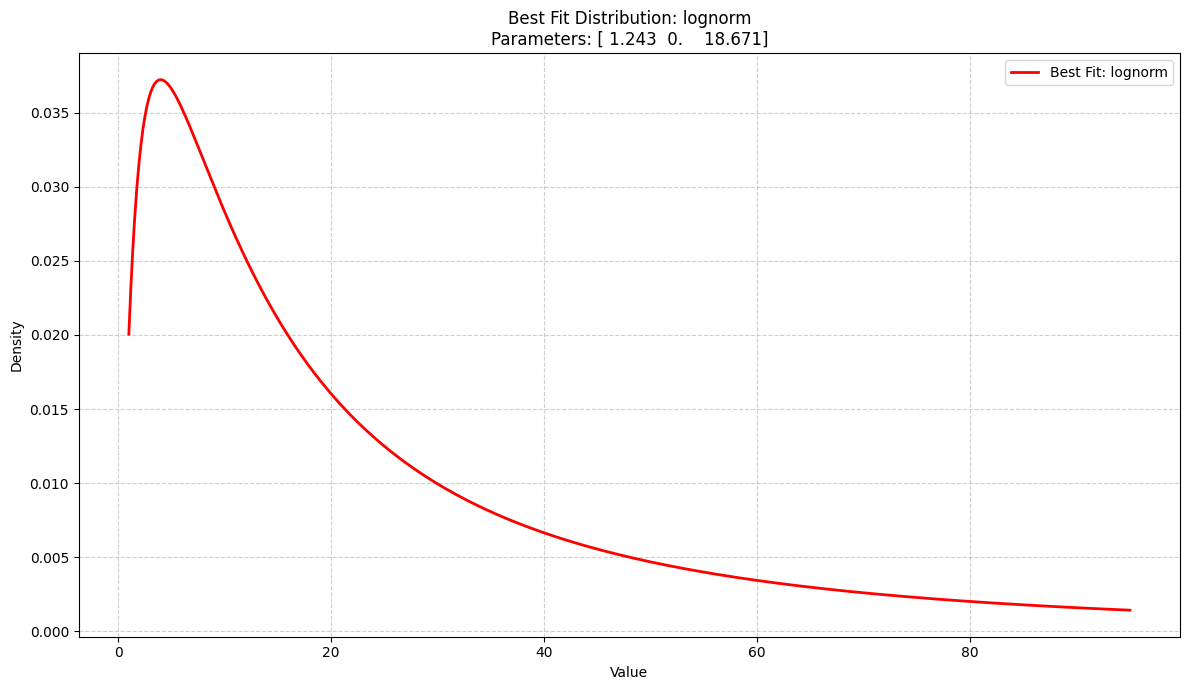

CULIACAN LAS TORRES


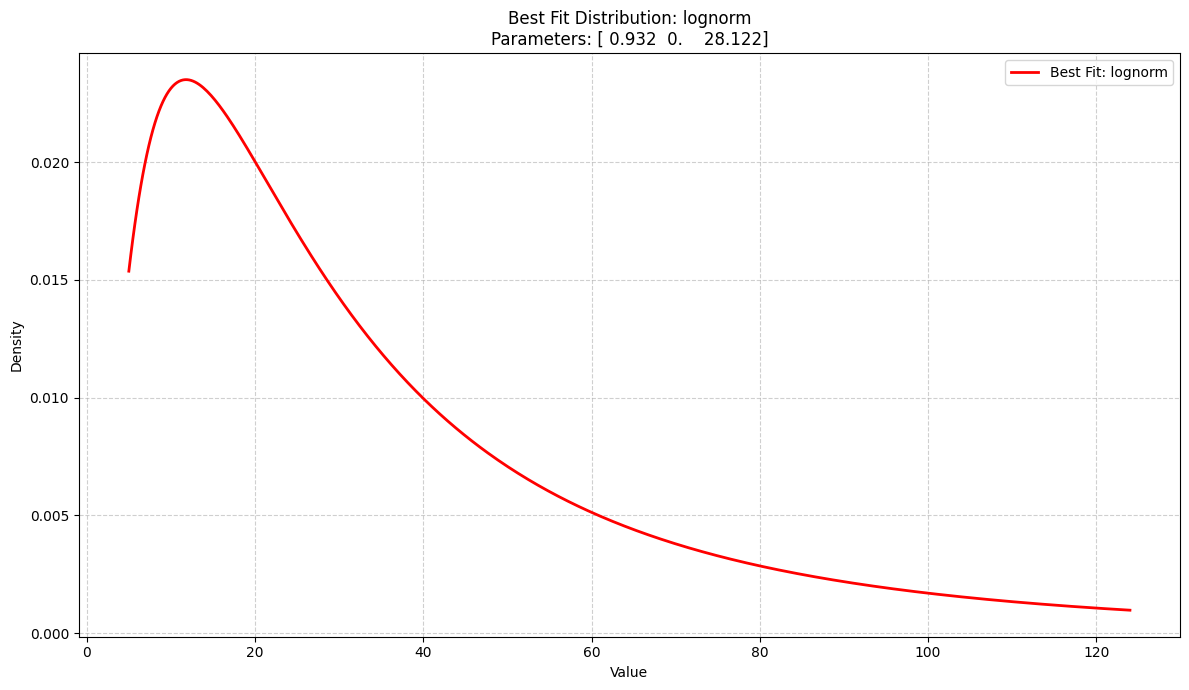

CULIACAN NAKAYAMA


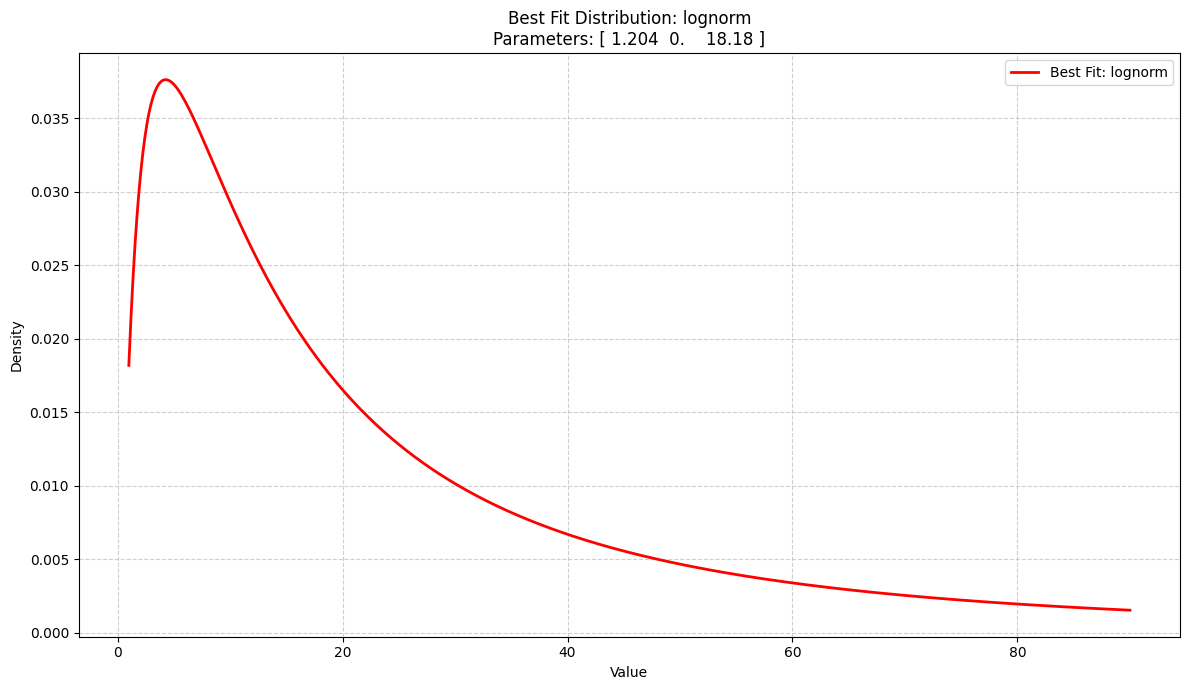

CULIACAN UNIVERSITARIOS


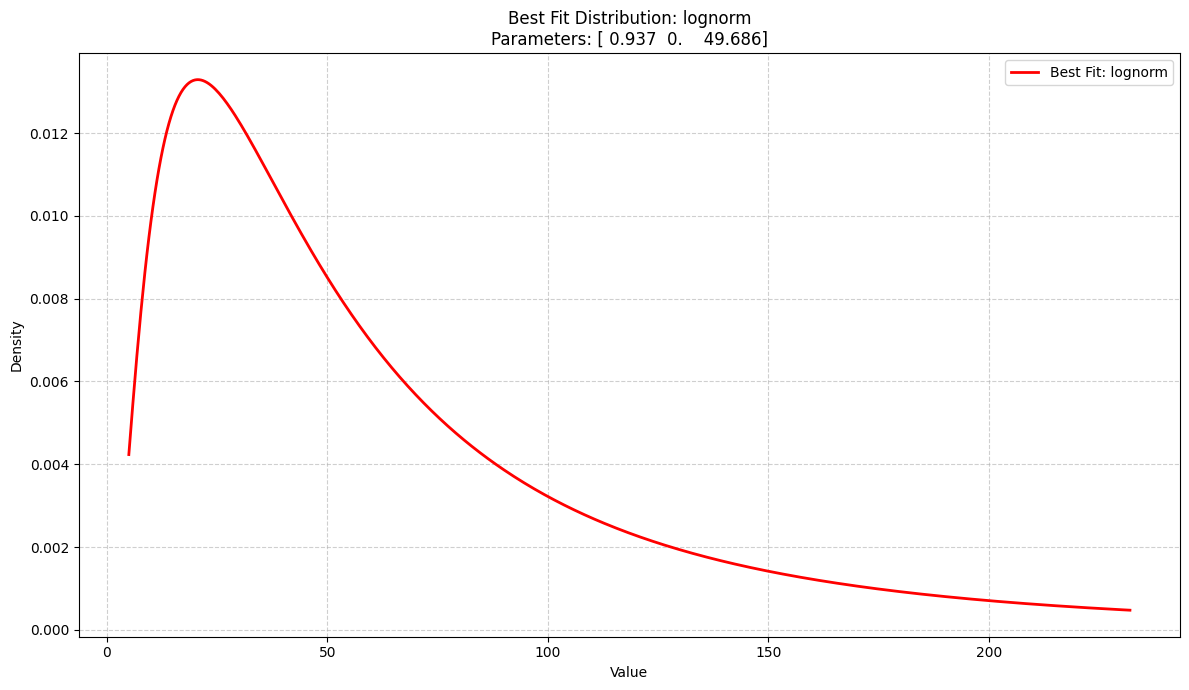

In [144]:
arrival_dist = {}
for key in distributions:
    print(key)
    dist, params = fit_best_distribution(distributions[key])
    plot_dist(dist, params, distributions[key])
    arrival_dist[key] = (dist.name, params)

In [145]:
arrival_dist

{'COYOACAN': ('lognorm', (1.2215397493446571, 0, 159.8405507423476)),
 'CULIACAN': ('gamma', (1.619495155616731, 0, 69.73310913636284)),
 'CULIACAN CAÑADAS': ('lognorm', (0.8652386361084784, 0, 56.198771730346856)),
 'CULIACAN COLEGIO MILITAR': ('lognorm',
  (1.119100236765752, 0, 40.92054951604537)),
 'CULIACAN LA CONQUISTA': ('lognorm',
  (1.2428355570733471, 0, 18.670752377463256)),
 'CULIACAN LAS TORRES': ('lognorm',
  (0.9317858441652889, 0, 28.12160263681599)),
 'CULIACAN NAKAYAMA': ('lognorm', (1.2036100393950178, 0, 18.17961711884912)),
 'CULIACAN UNIVERSITARIOS': ('lognorm',
  (0.9373100383273191, 0, 49.686044664249536))}

In [146]:
import json
with open('arrival_dist.json', 'w') as f:
    json.dump(arrival_dist, f, indent=4)